# <CENTER>**Comparación de Métodos de Aprendizaje de Máquina en el Análisis de Series Temporales Para la Predicción de Tasas de Cambio**</CENTER>
---
# <CENTER> **EAFIT 2024** </CENTER>

# **Estudiante**: Stevens Restrepo Vallejo
# **Coordinadora**: Paula Maria Almonacid Hurtado
---

## <CENTER>**IMPORTACIÓN DE BIBLIOTECAS**</CENTER>

Importamos las librerías a usar

In [48]:
from tensorflow.keras.layers import Conv1D, Input, Bidirectional, MaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.config import threading
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from functools import partial
from datetime import date


import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import tensorflow as tf
import multiprocessing
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import random

warnings.filterwarnings("ignore")

In [49]:
# Configura el número de hilos en las operaciones internas
num_processors = multiprocessing.cpu_count()
threading.set_intra_op_parallelism_threads(num_processors)
threading.set_inter_op_parallelism_threads(num_processors)

print("Using all available processors:", num_processors)

# Agrego semillas aleatorias para asegurarme que los experimentos en este programa sean reproducibles
def randoms(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Using all available processors: 16


## <CENTER>**DESCARGA DE DATOS**</CENTER>

---
### SE PLANTEA LA CONSTRUCCIÓN DEL PROBLEMA CON LA TASA DE CAMBIO DEL PAR **USD-COP** EN 5 AÑOS 
---

Definimos la divisa a analizar y el rango de fechas que usaremos

In [50]:
#Con esta función le pido al usuario que escriba el par de divisas que quiere evaluar y lo pongo en el formato de Yahoo Finance para la descarga.

def pairs(Curr_1, Curr_2):
    first_currency = Curr_1
    second_currency = Curr_2
    ticker = str(f'{first_currency}{second_currency}=X')
    return ticker

def descargar_información(years, Curr_1, Curr_2):
    #Obtengo los pares de divisas que voy a comparar
    ticker = pairs(Curr_1, Curr_2)

    #Defino los tiempos en los que evaluaré el par de divisas

    end_date = date.today()
    start_date = end_date.replace(year=end_date.year - years)
    end_date, start_date = str(end_date), str(start_date)

    Currencies = yf.download(ticker, start=start_date, end=end_date, progress=False)

    return Currencies, ticker

In [51]:
Curr_1 = input('Introduzca la primera divisa')
Curr_2 = input('Introduzca la segunda divisa')
years = int(input('¿Cuántos años de datos quieres evaluar?'))

Currencies, ticker = descargar_información(years, Curr_1, Curr_2)

In [52]:
#Visualizo mi tabla de datos

print(f'El par de divisas evaluado es: {ticker}')
data_backup = Currencies
data_backup

El par de divisas evaluado es: usdcop=X


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-04,3502.149902,3502.149902,3457.184814,3502.149902,3502.149902,0
2019-12-05,3468.750000,3468.770020,3454.020020,3468.750000,3468.750000,0
2019-12-06,3457.149902,3457.149902,3413.908691,3457.149902,3457.149902,0
2019-12-09,3422.750000,3428.050049,3379.253906,3422.750000,3422.750000,0
2019-12-10,3415.149902,3426.000000,3373.551514,3415.149902,3415.149902,0
...,...,...,...,...,...,...
2024-11-27,4401.250000,4411.080078,4397.520020,4401.250000,4401.250000,0
2024-11-28,4382.750000,4424.950195,4375.529785,4382.750000,4382.750000,0
2024-11-29,4416.459961,4432.870117,4382.000000,4416.459961,4416.459961,0


In [53]:
# Aislo los precios de cierre dentro de la variable data que será con la que estaremos trabajando
data = data_backup['Close']
data

Date
2019-12-04    3502.149902
2019-12-05    3468.750000
2019-12-06    3457.149902
2019-12-09    3422.750000
2019-12-10    3415.149902
                 ...     
2024-11-27    4401.250000
2024-11-28    4382.750000
2024-11-29    4416.459961
2024-12-02    4327.994141
2024-12-03    4457.750000
Name: Close, Length: 1305, dtype: float64

## <CENTER> **ANÁLISIS EXPLORATORIO** <CENTER>

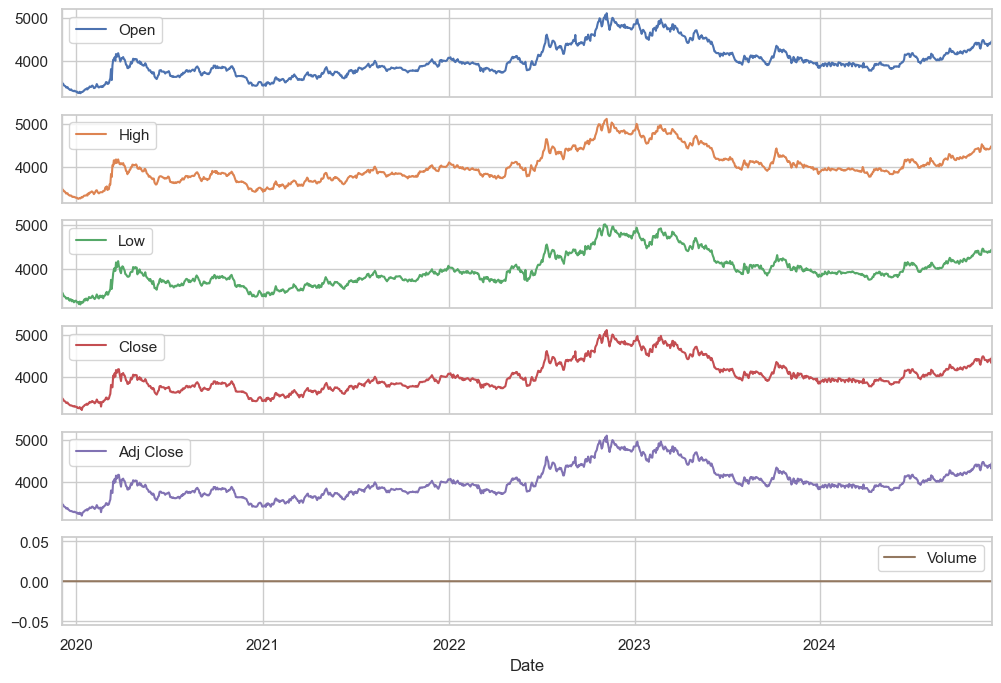

In [54]:
#Para visualizar los comportamientos del par de divisas en el tiempo

Currencies.plot(subplots = True, figsize = (12,8))
plt.legend()
plt.show()

In [55]:
def dickey_fuller_test(data):

    result = adfuller(data)

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.05:
        print("SERIE ESTACIONARIA.")
    else:
        print("La serie NO ES ESTACIONARIA.")

    print('\n')
    
    return result

#Función para graficar el ACF - PACF

def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series,zero = False, lags = 40, ax = axes[0], color= 'slategrey')
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1], color= 'slategrey')

    plt.show()

result = dickey_fuller_test(data)

ADF Statistic: -1.9376377645873453
p-value: 0.31456743779015456
Critical Values: {'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}
La serie NO ES ESTACIONARIA.




ADF Statistic: -9.270671488084378
p-value: 1.3294984938733685e-15
Critical Values: {'1%': -3.435457117423131, '5%': -2.863795358068796, '10%': -2.567970771161219}
SERIE ESTACIONARIA.




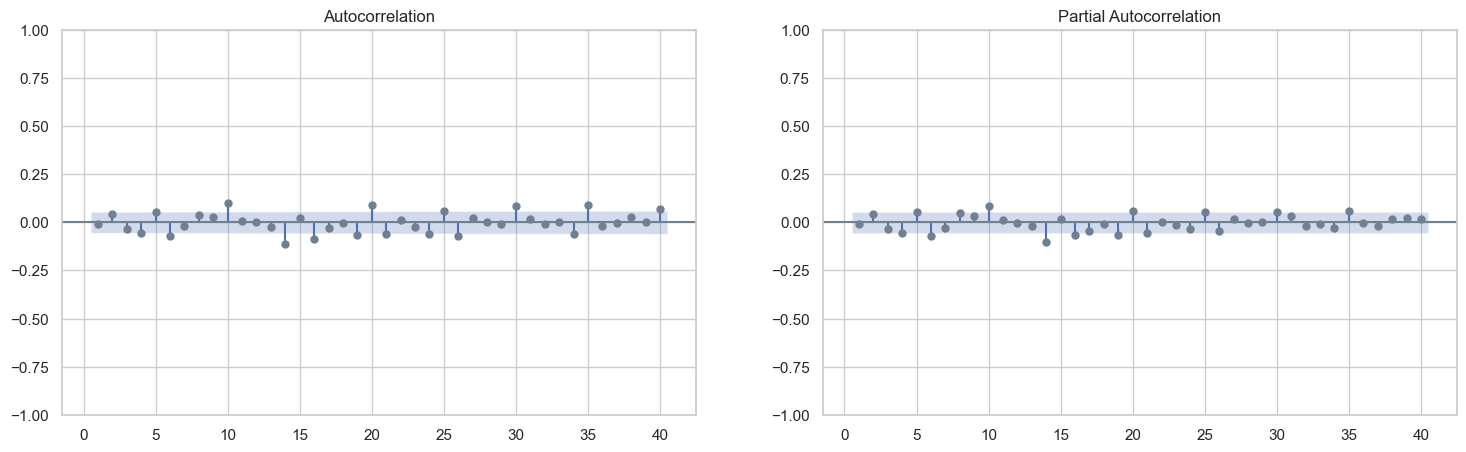

In [56]:
data_transformed = data.diff().dropna()
result = dickey_fuller_test(data_transformed)

plot_acf_pacf(data_transformed)

Cada 5 días se observa un patrón estacional en los datos que puede corresponder a la actividad de la bolsa de valores de lunes a viernes, por lo que definiremos para este par de divisas un número de 5 rezagos

In [57]:
#Defino el primer valor de la serie original para agregar al cumsum y revertir la serie con más precisión
first_value = data.iloc[0]

def rever_diff(series, initial_value):
    reverted_series = series.cumsum() + initial_value
    return reverted_series

In [58]:
data_reverted = rever_diff(data_transformed, first_value)
print(f'La suma de las diferencias al revertir la transformación en la data usando la función rever_diff es: {sum(data_reverted - data[1:])}')

La suma de las diferencias al revertir la transformación en la data usando la función rever_diff es: 0.0


Ahora reviso la volatilidad del activo en el tiempo a partir de sus rendimientos por cada día para definir cuáles serían valores atípicos en la serie basado en varianzas que superan un valor por encima o por debajo de los límites superior o inferior respectivamente. De esta forma encontramos los datos atípicos a ambos lados de la distribución de la volatilidad en el tiempo.

In [59]:
def calcular_volatilidad(data):

    # Calcular los rendimientos diarios
    volatilidad = data.pct_change()
    avrg =  np.nanmean(volatilidad)
    volatilidad = np.where(np.isnan(volatilidad), avrg, volatilidad)

    #Ordeno los valores de la volatilidad de menor a mayor
    volatilidad_ord = np.sort(volatilidad)

    #Establezco un alpha del 5% para particionar la cola derecha de la distribución de volatilidad
    alpha = 0.05

    particion_sup = round(len(volatilidad_ord)*(1-alpha/2))
    particion_inf = round(len(volatilidad_ord)*(alpha/2))

    upper_limit = volatilidad_ord[particion_sup]
    lower_limit = volatilidad_ord[particion_inf]


    return lower_limit, upper_limit, volatilidad_ord, volatilidad

Dado que para la distribución se deberían solo considerar los valores de la cola derecha de la distribución como datos atípicos, se considerarán como atípicos solo aquellos valores superiores a 1-$\alpha$ cuando los datos están ordenados, esta volatilidad es indicador de que el dato tuvo un comportamiento atípico y servirá también para determinar si una predicción está dentro del comportamiento normal del par de divisas o no.

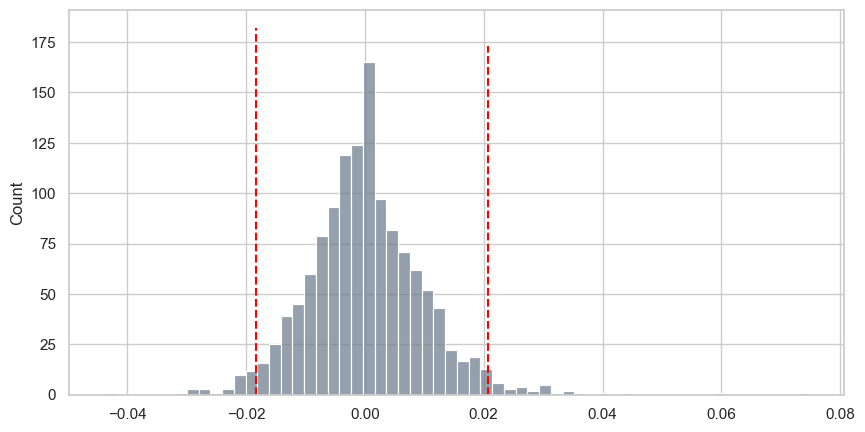

El límite inferior es -0.018319600034365946, mientras el superior es 0.020689827018536278


In [60]:
lower_outliers, upper_outliers, volat_ord, volatilidad = calcular_volatilidad(data)

#Graficar
plt.figure(figsize=(10,5))
sns.histplot(volat_ord, color= 'slategrey')
plt.vlines(upper_outliers, ymin=0, ymax=plt.gca().get_ylim()[1], color='red', linestyle='--', label='Upper Outlier')
plt.vlines(lower_outliers, ymin=0, ymax=plt.gca().get_ylim()[1], color='red', linestyle='--', label='Lower Outlier')
plt.show()

print(f'El límite inferior es {lower_outliers}, mientras el superior es {upper_outliers}')

## <CENTER> **PREPARACIÓN DE LA DATA** </CENTER>

In [61]:
def agregar_características_rezagadas(arr=None, num_lags=0, array_outliers=None):
    # Asegúrate de que arr sea un array 1D
    arr = np.asarray(arr).flatten()  # Convierte a un array 1D
    n_samples = len(arr)

    # Crear un nuevo array para almacenar las características de lag
    lagged_data = np.zeros((n_samples - num_lags, num_lags + 1))  # (n_samples - num_lags, num_lags + 1)
    
    # Llenar la primer columna con los datos originales
    lagged_data[:, 0] = arr[num_lags:]  # Los datos originales sin los primeros 'num_lags' elementos

    # Llenar las columnas de lag
    for i in range(1, num_lags + 1):
        lagged_data[:, i] = arr[num_lags - i:n_samples - i]  # Datos con el retraso correspondiente

    vol_array = array_outliers[num_lags:].reshape(-1, 1)
    lagged_data = np.hstack((lagged_data, vol_array))

    return lagged_data

In [62]:
#La función a continuación sirve para particionar los datos de train, val y para particionar los datos de test. Si el parámetro test = 1, entonces solo transforma los datos de test y no particiona train - val

def particionar_datos(alpha, train_set, test=False):
    if test == False:
        #Hago particiones en mi dataset con un punto de corte del 90%
        train_size = int(len(train_set)*alpha)
       
        # Separo el conjunto de entrenamiento de el de validación
        train_df = train_set[:train_size]
        val_df = train_set[train_size:]

        # Separo X, y en X_train, y_train y X_val, y_val para cada conjunto
        X_train = train_df[:,1:]
        y_train = train_df[:,0]
        X_val = val_df[:,1:]
        y_val = val_df[:,0]

        return X_train, y_train, X_val, y_val
    
    else:
        X_test = train_set[:,1:]
        y_test = train_set[:,0]

        return X_test, y_test

In [63]:
# Defino el número de rezagos basado en la ACF PACF
num_lags = 5

# Creamos un objeto standard scaler
out_scaler = StandardScaler()

data_scaled = out_scaler.fit_transform((data.to_frame()))
data_preprocessed = agregar_características_rezagadas(arr=data_scaled, num_lags=num_lags, array_outliers=volatilidad)

# Defino un punto para particionar mis datos basado en un 10% de datos a predecir

train_size = 0.9
split = int(len(data_preprocessed)*train_size)

train_df = data_preprocessed[:split]
test_df = data_preprocessed[split:]

# Separamos los datos en características (X) y etiquetas (y)
X_train_base, y_train_base, X_val_base, y_val_base = particionar_datos(train_size, train_df)
X_test_base, y_test_base = particionar_datos(train_size, test_df, test=1)

In [64]:
data_preprocessed_tf = agregar_características_rezagadas(arr=data_transformed, num_lags=num_lags, array_outliers=volatilidad[1:])

split_2 = split-1 # La data transformado tiene un dato menos por la primera diferenciación

train_df_transformed = data_preprocessed_tf[:split_2]
test_df_transformed = data_preprocessed_tf[split_2:]

X_train_tf, y_train_tf, X_val_tf, y_val_tf = particionar_datos(train_size, train_df_transformed)
X_test_tf, y_test_tf = particionar_datos(train_size, test_df_transformed, test=True)

Se cuenta con un total de 1174 días como datos de entrenamiento y otros 131 días como datos de prueba en total. Todos los datos tienen sus índices como fechas en el formato datetime y una única columna con el valor del cierre de la tasa de cambio para ese día. Todos los valores que aquí serán evaluados corresponden al precio de cierre de dos pares de divisas en una fecha específica.

El escalado de datos solo se hará sobre el conjunto sin transformaciones para convertir la serie en estacionaria pues la diferenciación ya por sí misma estabiliza la varianza de los datos para series heterocedásticas.

In [65]:
def plot_series(y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.figure(figsize=(12,5))
    sns.set(style="whitegrid")

    # Calcular los límites de volatilidad para y
    if y is not None:
        y = y.flatten() if len(y.shape) > 1 else y
        lower_limit_y, upper_limit_y, _, _ = calcular_volatilidad(pd.Series(y))
        outliers_y = [i for i, val in enumerate(y) if val < lower_limit_y or val > upper_limit_y]

    # Graficar los valores reales en línea discontinua y color slategrey
    if y is not None:
        plt.plot(np.arange(len(y)), y, linestyle='--', label="$y(t)$ Real", color='#97a6c4', linewidth=3)

    # Graficar los valores predichos como puntos en color slateblue
    if y_pred is not None:
        plt.plot(np.arange(len(y_pred)), y_pred, linestyle='-.', linewidth=3 ,color='#384860', label="Predicción")

    # Graficar los outliers de y en color crimson
    if y is not None and outliers_y:
        plt.scatter(outliers_y, [y[i] for i in outliers_y], color='#298c8c', s=11, label="Outliers", zorder=5)

    # Configurar etiquetas y estilos
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.grid(True)
    plt.autoscale()

    # Mostrar la leyenda solo si hay valores reales o predicciones
    if legend and (y is not None or y_pred is not None):
        plt.legend(fontsize=14, loc="upper left")

    plt.show()

El conjunto de datos se separó en 3 partes, una para entrenar el modelo, otra para validación y otra para test. El conjunto de validación se separa con dos fines:

1. Hacer un espacio entre los datos de entrenamiento y prueba de forma que una buena predicción en test no esté anclado a la disponibilidad de los datos de sus días anteriores.
2. Poder tener un referente del error de generalización de los modelos en el conjunto de validación contra el conjunto de prueba.

In [66]:
print(X_train_base.shape)
print(y_train_base.shape)

print(f'\n',X_train_tf.shape)
print(y_train_tf.shape)

(1053, 6)
(1053,)

 (1052, 6)
(1052,)


### <Center> **ARREGLO A LOS DATOS PARA MODELOS BASADOS EN REDES**</center>

El modelo híbrido está compuesto por una red neuronal convolucional (CNN por sus siglas en inglés) y por un modelo de redes neuronales Long-Short Term Memory, esta combinación permite extraer las mejores características de ambos algoritmos al combinar la facilidad de extracción de características en la X que representa la CNN, mientras que LSTM se especializa en la comprensión de los patrones a largo plazo en los conjuntos de datos.

De esta forma, dado que las redes neuronales convolucionales requieren mínimamente un conjunto con 3 dimensiones, agregaremos una ventana deslizante de N días a los datos y construiremos el modelo híbrido de la siguiente manera:

De esta forma tenemos que:

- características: Se refiere a la matriz de características rezagadas original
- n_steps_in: Genera una ventana de tiempo de N pasos que toma los últimos N vectores para añadirlos al tensor
- n_steps_out: Hace referencia al número de pasos de salida que tiene el modelo, en este caso esperamos que la salida sea una única predicción

In [67]:
def ventana_tiempo(caracteristicas, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(caracteristicas)):
        # Aseguramos que el tamaño de la ventana no salga del rango de los datos
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        if out_end_ix > len(caracteristicas):
            break
        
        # Extracto la característica actual como X (de la fila) y la salida como y (de la misma fila)
        seq_x = caracteristicas[i:end_ix, 1:]  # Las 6 características del vector, sin incluir la primera
        seq_y = caracteristicas[i, 0]  # El primer valor de la misma fila
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 5,1 # Número de filas con características que se ingresan al modelo y número de predicciones

In [68]:
#Hago particiones en mi dataset con un punto de corte del 90%
split_NNs = int(len(train_df)*train_size)

# Separo el conjunto de entrenamiento de el de validación y prueba
train_nets = train_df[:split_NNs]
val_nets = train_df[split_NNs:]
test_nets = test_df


In [69]:
X_CNN, y_CNN = ventana_tiempo(train_nets, n_steps_in, n_steps_out)

# Esto debería dar una forma (num_samples, window_size, num_features)
print(f'X_CNN es de la forma: {X_CNN.shape}, y y_CNN es de forma {y_CNN.shape}')

X_CNN_val, y_CNN_val = ventana_tiempo(val_nets, n_steps_in, n_steps_out)
print(f'X_CNN_Val es de la forma: {X_CNN_val.shape}, y y_CNN_Val es de forma {y_CNN_val.shape}')

X_CNN_test, y_CNN_test = ventana_tiempo(test_nets, n_steps_in, n_steps_out)
print(f'X_CNN_test es de la forma: {X_CNN_test.shape}, y y_CNN_test es de forma {y_CNN_test.shape}')

X_CNN es de la forma: (1048, 5, 6), y y_CNN es de forma (1048,)
X_CNN_Val es de la forma: (112, 5, 6), y y_CNN_Val es de forma (112,)
X_CNN_test es de la forma: (125, 5, 6), y y_CNN_test es de forma (125,)


In [70]:
def plot_learning_curves(loss, val_loss):
    epochs = np.arange(len(loss)) + 1
    sns.set(style="whitegrid")
    
    # Crear la gráfica con Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epochs, y=loss, marker="o", label="Pérdida en entrenamiento", color="slateblue")
    sns.lineplot(x=epochs, y=val_loss, marker="o", label="Pérdida en validación", color="slategrey")
    
    # establezco los límites del eje y para visualizar mejor
    max_value = max(max(loss), max(val_loss))
    plt.ylim(0, max_value)
    
    # etiquetas y legendas de los ejes
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Función de pérdida", fontsize=14)
    plt.title("Curva de aprendizaje", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    plt.show()

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

## <center> **CONSTRUCCIÓN DE MODELOS** </center>

### <center> **MODELO LINEAL DE BASE** </center>

In [71]:
#Entreno mi modelo

model = LinearRegression()
model.fit(X_train_base, y_train_base)

model_tf = LinearRegression()
model_tf.fit(X_train_tf, y_train_tf)

LinearRegression()

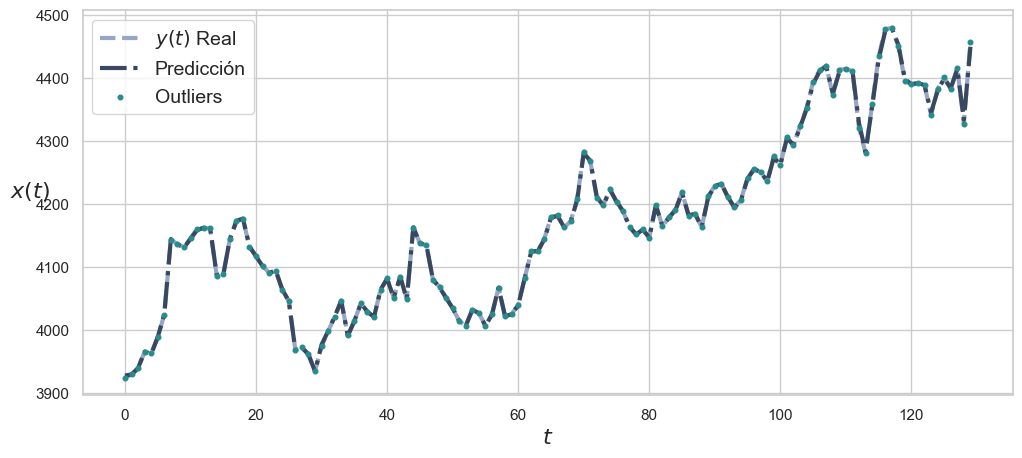

La función de pérdida (MSE) del modelo de base es de: 2.8372138149129786


In [72]:
y_real = out_scaler.inverse_transform(y_test_base.reshape(-1,1))
y_pred = out_scaler.inverse_transform(model.predict(X_test_base).reshape(-1, 1))

loss_base_model = root_mean_squared_error(y_real, y_pred)**2

plot_series(y_real, y_pred)
plt.show()

print(f'La función de pérdida (MSE) del modelo de base es de: {loss_base_model}')

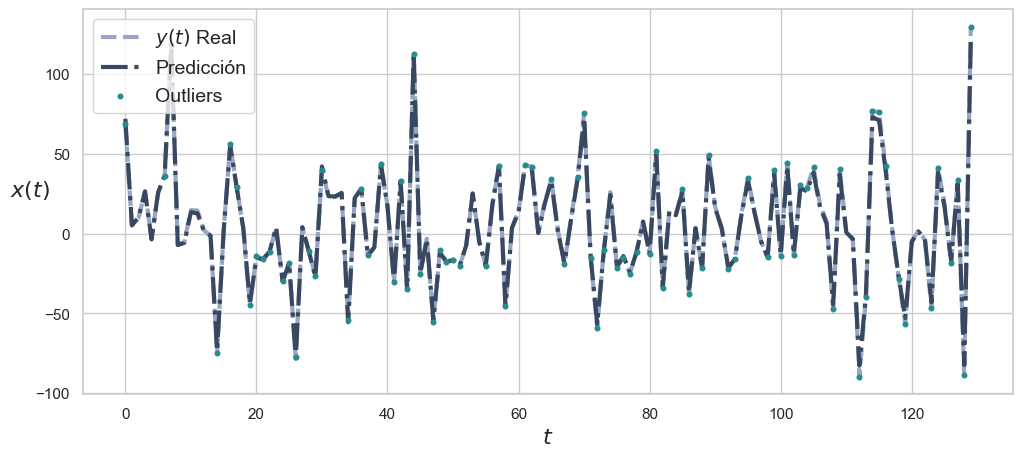

In [73]:
y_real_tf = y_test_tf.reshape(-1,1)
y_pred_tf = model_tf.predict(X_test_tf).reshape(-1, 1)

plot_series(y_real_tf, y_pred_tf)
plt.show()



A pesar de que a través de la diferenciación la serie temporal se convierte en estacionaria, seguir los patrones de los datos para un modelo lineal será mucho más complejo, en especial cuando los datos  toman cambios de dirección fuertes a causa de comportamientos atípicos dentro de los datos. 

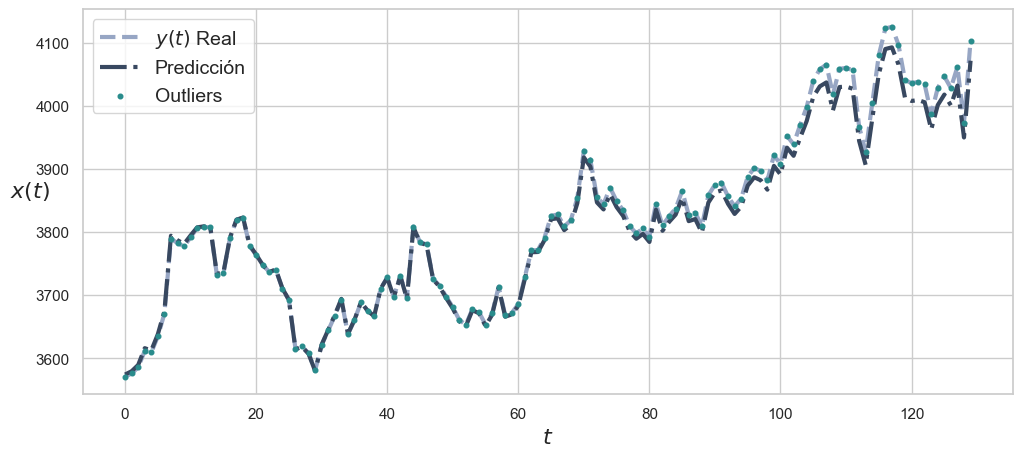

La función de pérdida (MSE) del modelo de base es de: 197.41827080073054


In [74]:
y_real_tf = rever_diff(y_real_tf, first_value)
y_pred_tf = rever_diff(y_pred_tf, first_value)

loss_base_model_tf = root_mean_squared_error(y_real_tf, y_pred_tf)**2

plot_series(y_real_tf, y_pred_tf)
plt.show()

print(f'La función de pérdida (MSE) del modelo de base es de: {loss_base_model_tf}')

Al revertir la transformación de la diferenciación, se puede observar que debido a los errores acumulados en la predicción del modelo, la escala de la moneda cambia al revertir la transformación, adicionalmente, el modelo que no usa los datos diferenciados tiene mejor rendimiento por lo que se descarta usar datos con diferenciación en este proyecto.

### <Center> **MODELO RANDOM FOREST REGRESSOR**</center>

In [75]:
#Entreno mi modelo de árboles aleatorios

rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_base, y_train_base)

rf_tf = RandomForestRegressor(random_state=42)
rf_tf.fit(X_train_tf, y_train_tf)

RandomForestRegressor(random_state=42)

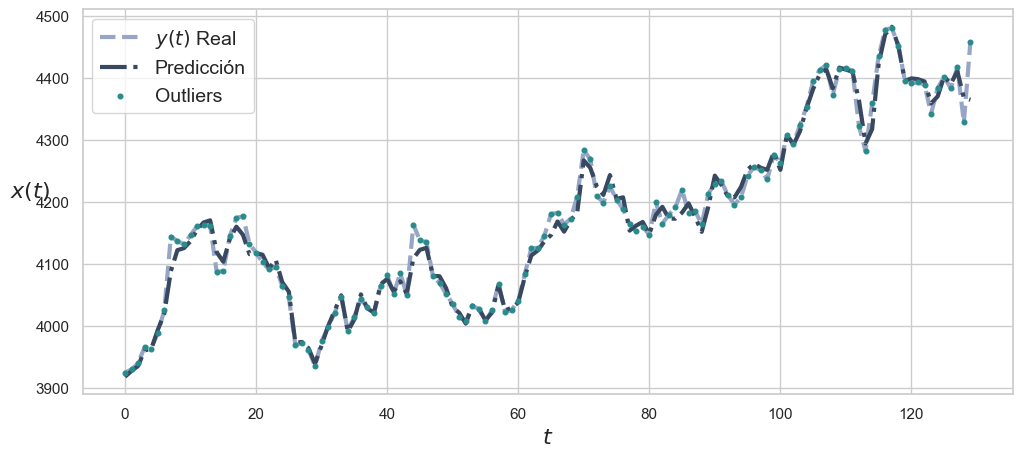

La función de pérdida (MSE) del modelo de base es de: 270.67346951124756


In [76]:
y_real = out_scaler.inverse_transform(y_test_base.reshape(-1,1))
y_pred = out_scaler.inverse_transform(rf_base.predict(X_test_base).reshape(-1, 1))

loss_base_model = root_mean_squared_error(y_real, y_pred)**2

plot_series(y_real, y_pred)
plt.show()

print(f'La función de pérdida (MSE) del modelo de base es de: {loss_base_model}')

### <Center> **MODELO LSTM**</center>

In [77]:
class LSTM_Model:
    def __init__(self, n_steps_in=n_steps_in, num_lags=0, seed=42, lr_scheduler=None):
        self.n_steps_in = n_steps_in
        self.num_lags = num_lags
        self.model = self.build_model()
        randoms(seed)

        # Definir un lr_scheduler por defecto si no se pasa uno
        if lr_scheduler is None:
            self.lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        else:
            self.lr_scheduler = lr_scheduler        

    def build_model(self):
        # Definir el modelo LSTM
        model = Sequential([
            Bidirectional(LSTM(units=256, activation='relu')), 
            Dense(1)  # Capa de salida
        ])
        
        # Compilar el modelo
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self, X, y, epochs=20, batch_size=60, **kwargs):
        return self.model.fit(X, y, epochs=epochs, batch_size=batch_size, **kwargs, callbacks=[self.lr_scheduler])

    def predict(self, X, **kwargs):
        return self.model.predict(X, **kwargs)
    
    
    def __call__(self):
        # Devolver el modelo directamente cuando se llame a la instancia
        return self.model
    
    def __str__(self):
        # Este método define cómo se representará el nombre de la instancia
        return "LSTM_Model"

# Instancia la clase
LSTM_model = LSTM_Model(n_steps_in, num_lags+1)

# Obtener el modelo al llamar la clase
Modelo_LSTM = LSTM_model()

In [78]:
history = Modelo_LSTM.fit(X_CNN, y_CNN, epochs=20, validation_data=(X_CNN_val, y_CNN_val), callbacks=lr_scheduler)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3449 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 10/20
33/33 ━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


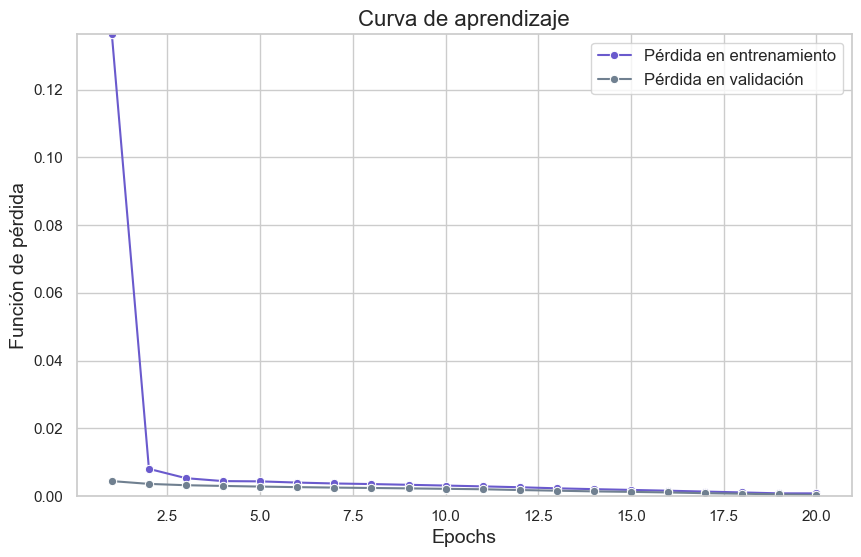

In [79]:
# Hago predicciones y reescalo la y para ver los precios reales
y_real = out_scaler.inverse_transform((y_CNN_test).reshape(-1,1))
y_pred = out_scaler.inverse_transform(Modelo_LSTM.predict(X_CNN_test).reshape(-1, 1))
LSTM_model_loss = root_mean_squared_error(y_real, y_pred)**2

# Guardar la pérdida en entrenamiento y validación
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_learning_curves(training_loss, validation_loss )

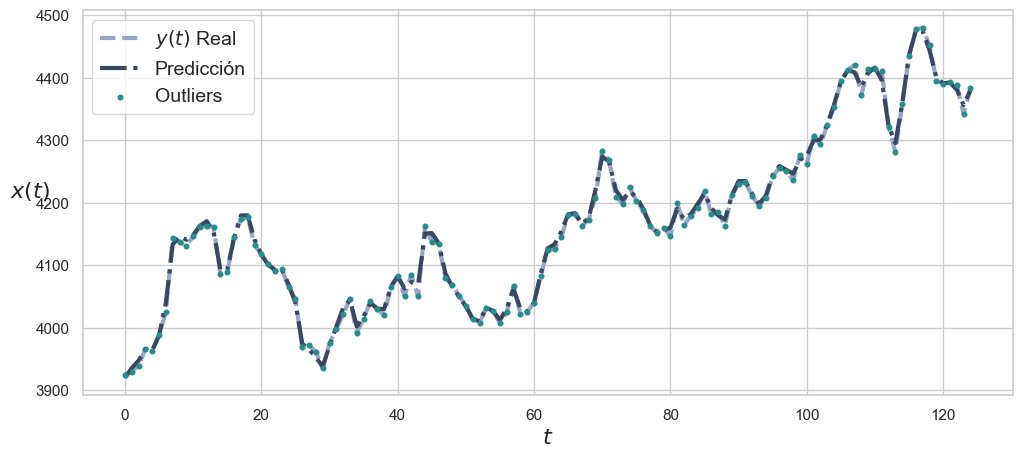

La pérdida del modelo LSTM en el conjunto de prueba es de: 46.455233406066895


In [80]:
plot_series(y_real, y_pred)
print(f'La pérdida del modelo LSTM en el conjunto de prueba es de: {LSTM_model_loss}')

### <Center> **MODELO HÍBRIDO**</center>

In [81]:
class Conv_LSTM:
    def __init__(self, n_steps_in=n_steps_in, num_lags=None, seed=42, lr_scheduler=None):
        self.n_steps_in = n_steps_in
        self.num_lags = num_lags
        self.model = self.build_model()
        randoms(seed)

        # Definir un lr_scheduler por defecto si no se pasa uno
        if lr_scheduler is None:
            self.lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        else:
            self.lr_scheduler = lr_scheduler

    def build_model(self):
        # Defino la arquitectura del modelo
        model = Sequential([
            Conv1D(
                filters=256,
                kernel_size=1,
                activation='relu',
                padding='causal'
            ),
            Bidirectional(LSTM(units=256, activation='relu')), 
            Dense(1)  # Capa de salida
        ])

        # Compilar el modelo
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def fit(self, X, y, epochs=20, batch_size=60, **kwargs):
        return self.model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[self.lr_scheduler], **kwargs)
    
    def predict(self, X, **kwargs):
        return self.model.predict(X, **kwargs)

    def __call__(self):
        # Retorna el modelo directamente
        return self.model
    
    def __str__(self):
        # Este método define cómo se representará el nombre de la instancia
        return "CONV_LSTM_Model"

# Instancia la clase
conv_LSTM = Conv_LSTM(n_steps_in, num_lags)

# Obtener el modelo al llamar la clase y obtener los archivos de respaldo
Hybrid_model = conv_LSTM()

In [82]:
# history = Hybrid_model.fit(X_CNN, y_CNN, epochs=20, validation_data=(X_CNN_val, y_CNN_val), callbacks=lr_scheduler)
history = Hybrid_model.fit(X_CNN, y_CNN, epochs=20, validation_data=(X_CNN_val, y_CNN_val), callbacks=lr_scheduler)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.2962 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 10/20
33/33 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


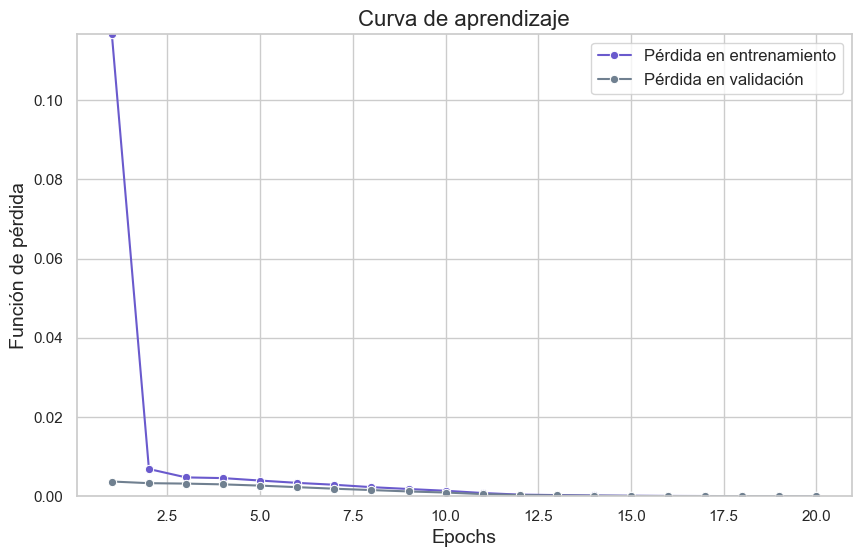

In [83]:
# Hago predicciones y reescalo la y para ver los precios reales
y_real = out_scaler.inverse_transform((y_CNN_test).reshape(-1,1))
y_pred = out_scaler.inverse_transform(Hybrid_model.predict(X_CNN_test).reshape(-1, 1))
Hybrid_model_loss = root_mean_squared_error(y_real, y_pred)**2

#Guardar la pérdida en entrenamiento y validación
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_learning_curves(training_loss, validation_loss )

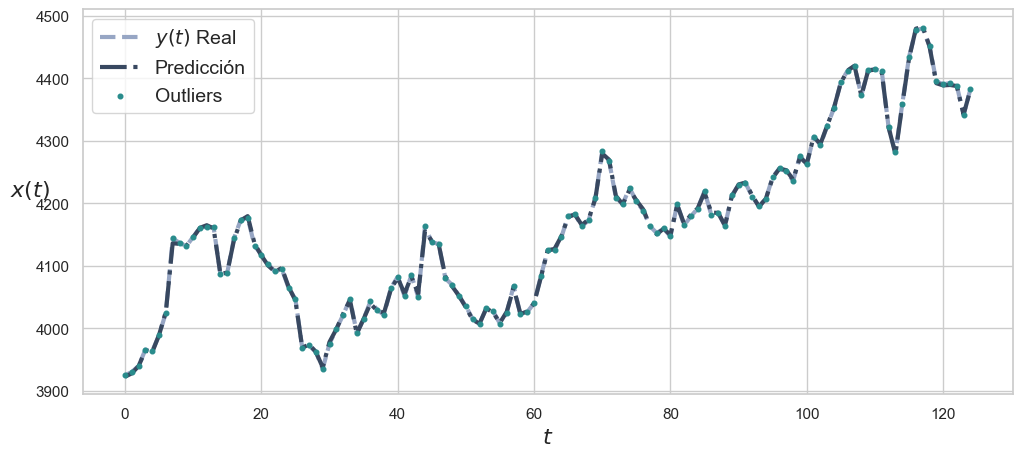

La pérdida del modelo híbrido en el conjunto de prueba es de: 4.195051131725312


In [84]:
plot_series(y_real, y_pred)
print(f'La pérdida del modelo híbrido en el conjunto de prueba es de: {Hybrid_model_loss}')

## <CENTER> **PIPELINE DE ENTRENAMIENTO** </CENTER>

In [85]:
lstm = LSTM_Model()
hybrid = Conv_LSTM()
lr = LinearRegression()
rf = RandomForestRegressor()

In [86]:
#Agrego una clase para ayudar a inicializar el pipeline en la función lag_features
class LagFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_lags=None, array_outliers=None):
        self.num_lags = num_lags
        self.array_outliers = array_outliers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Llama a la función agregar_características_rezagadas
        return agregar_características_rezagadas(X, self.num_lags, self.array_outliers)

In [87]:
def entrenar_modelo(alpha, modelo, years=None, Curr_1=None, Curr_2=None, num_lags=None, plot=True):

    num_lags_models = num_lags + 1

    #Inicializo el modelo para que reinicie el entrenamiento desde cero y no desde el último ciclo de entrenamiento
    if isinstance(modelo, LSTM_Model):
        modelo = LSTM_Model(n_steps_in, num_lags_models)  # Reinicia el modelo LSTM
    elif isinstance(modelo, Conv_LSTM):
        modelo = Conv_LSTM(n_steps_in, num_lags_models)  # Reinicia el modelo Conv_LSTM

    # Descargamos los datos y obtenemos el ticker
    data, ticker = descargar_información(years, Curr_1, Curr_2)
    data = data['Close']
    if plot==True:
        print("\n")
        print(f'El par de divisas evaluado es: {ticker}', "\n")

    randoms(42)

    #Calculo la volatilidad de mis datos
    upper_outliers, lower_outliers, volatilidad_datos, volatility_array = calcular_volatilidad(data)

    # Crear el pipeline con el transformador de características de rezago
    pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('lag_features', LagFeatureTransformer(num_lags=num_lags, array_outliers=volatility_array)),
        ('model', modelo)
    ])

    # Escalamos los datos y agregamos las características de rezago
    scaled_data = pipeline.named_steps['scaling'].fit_transform(data.to_frame())
    data_preprocessed = pipeline.named_steps['lag_features'].fit_transform(scaled_data)

    # Partición inicial de los datos en train y test
    train_size = alpha
    split = int(len(data_preprocessed) * train_size)
    train_df = data_preprocessed[:split]
    test_df = data_preprocessed[split:]

    # Separamos los datos en características (X) y etiquetas (y)
    X_train, y_train, X_val, y_val = particionar_datos(train_size, train_df)
    X_test, y_test = particionar_datos(train_size, test_df, test=1)

    # Si el modelo es LSTM o Conv_LSTM, aplicar ventana de tiempo
    if isinstance(modelo, (LSTM_Model, Conv_LSTM)):
        split_nn = int(len(train_df)*train_size)
        train_df2 = train_df[:split_nn]
        val_df = train_df[split_nn:]

        X_train, y_train = ventana_tiempo(train_df2, n_steps_in, n_steps_out)
        X_val, y_val = ventana_tiempo(val_df, n_steps_in, n_steps_out)
        X_test, y_test = ventana_tiempo(test_df, n_steps_in, n_steps_out)
        pipeline.named_steps['model'].fit(X_train, y_train, verbose=0)
        y_real, y_pred = y_test, pipeline.named_steps['model'].predict(X_test, verbose=0)
    else:
        pipeline.named_steps['model'].fit(X_train, y_train)
        y_real, y_pred = y_test, pipeline.named_steps['model'].predict(X_test)

    y_real = pipeline.named_steps['scaling'].inverse_transform(y_real.reshape(-1, 1))
    y_pred = pipeline.named_steps['scaling'].inverse_transform(y_pred.reshape(-1, 1))
    values = y_real, y_pred

    # Cálculo de la pérdida del modelo
    model_loss = root_mean_squared_error(y_real, y_pred)**2

    if plot==True:
        # Graficar predicciones vs. valores reales
        plot_series(y_real, y_pred)
        plt.show()
        print(f'La función de pérdida (MSE) del modelo de {modelo} es de: {model_loss}')

    return pipeline, X_test, model_loss, values



El par de divisas evaluado es: USDCOP=X 



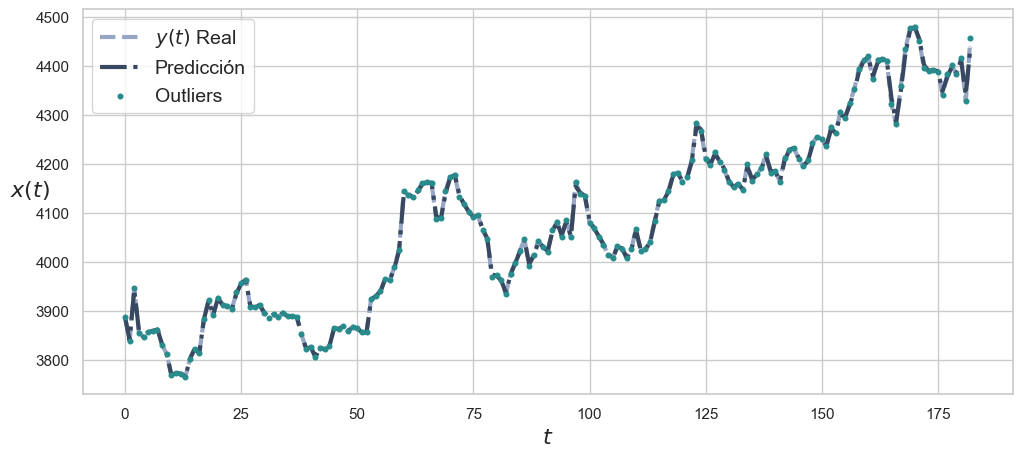

La función de pérdida (MSE) del modelo de LinearRegression() es de: 12.195261078337644


In [88]:
pipeline, X_test, model_loss, values = entrenar_modelo(alpha=0.9, modelo=lr, Curr_1='USD', Curr_2='COP', years=7, num_lags=num_lags, plot=True)

Temporalmente, el modelo híbrido demuestra tener mejores resultados al generalizar sobre datos desconocidos (Test) para este par de divisas (USD, COP) en un periodo de 5 años, es por esto que se usará el modelo híbrido para hacer predicciones a futuro uno a uno

## <Center> **PREDICCIONES**</center>

In [89]:
def predict_n_steps_ahead(pipeline, initial_data, n_steps=None):
    # Obtener el modelo del pipeline
    model = pipeline.named_steps['model']
    
    # Inicializar last_data con el último registro de initial_data
    last_data = initial_data[-1].copy()  # Último paso de datos (debe ser 1D)

    # Lista para almacenar las predicciones
    rolling_predictions = []
    
    # Realizamos predicciones dependiendo del tipo de modelo
    if isinstance(model, (RandomForestRegressor, LinearRegression)):
        for _ in range(n_steps):
            # Preparamos los datos para la predicción (incluir rendimiento actual)
            input_data = last_data.reshape(1, -1)  # Mantenemos las 6 características
            
            # Realizamos la predicción
            pred = pipeline.named_steps['model'].predict(input_data)  
            rolling_predictions.append(pred[0])  # Almacenamos el valor de predicción
            
            # Actualizamos los datos para la siguiente predicción
            last_data[:-1] = np.roll(last_data[:-1], shift=-1)  # Desplazamos las primeras 5 características hacia la izquierda
            last_data[-2] = pred[0]  # Sustituimos el penúltimo valor con la nueva predicción
            
            # Calcular el rendimiento respecto al paso anterior
            if len(rolling_predictions) > 1:
                rendimiento = (pred[0] - rolling_predictions[-2]) / abs(rolling_predictions[-2])
                last_data[-1] = rendimiento  # Actualizamos el último valor con el nuevo rendimiento
            else:
                last_data[-1] = initial_data[-1,-1]  # Inicializa el rendimiento en el primer paso

        rolling_predictions = np.array(rolling_predictions).reshape(-1, 1)
        rolling_predictions = pipeline.named_steps['scaling'].inverse_transform(rolling_predictions)

    elif isinstance(model, (LSTM_Model, Conv_LSTM)):
        for _ in range(n_steps):
            # Preparamos los datos para la predicción (debe tener forma (1, 5, 6))
            input_data = last_data.reshape(1, 5, -1)
            
            # Realizamos la predicción
            pred = model.predict(input_data)
            rolling_predictions.append(pred[0, 0])  # Almacenamos la predicción
            
            # Actualizamos last_data para la siguiente iteración
            last_data = np.roll(last_data, shift=-1, axis=0)  # Desplazamos los datos hacia arriba
            last_data[-1, :-1] = pred[0, 0]  # Sustituimos la última fila con la predicción
            # Calcular el rendimiento respecto al paso anterior
            if len(rolling_predictions) > 1:
                rendimiento = (pred[0, 0] - rolling_predictions[-2]) / abs(rolling_predictions[-2])
                last_data[-1, -1] = rendimiento  # Actualizamos el rendimiento
            else:
                last_data[-1, -1] = initial_data[-1, -1, -1]  # Inicializa el rendimiento con el último valor original

        rolling_predictions = np.array(rolling_predictions).reshape(-1, 1)
        rolling_predictions = pipeline.named_steps['scaling'].inverse_transform(rolling_predictions)

    return rolling_predictions, last_data

In [90]:
# Proporciono el último dato de la serie con sus 7 rezagos como punto de partida para las próximas predicciones
initial_data= X_test
n_steps = 2

# Ejecuto mi función
rolling_predictions, last_data = predict_n_steps_ahead(pipeline, initial_data, n_steps=n_steps)

In [91]:
# Imprimo un array con mis resultados.
print("Próximos datos predichos con el modelo:", rolling_predictions)

Próximos datos predichos con el modelo: [[4439.39090268]
 [4529.67583198]]


In [92]:
def imprimir_predicciones(values):# Concatenar los valores
    y_real, y_pred_extract = values
    combined_predictions = np.concatenate([y_pred_extract, rolling_predictions])
    x_values = np.arange(len(combined_predictions))

    # Crear la gráfica
    plt.figure(figsize=(12,5))
    plt.plot(x_values, combined_predictions, marker='o')

    # Crear la gráfica
    plt.plot(x_values[:len(y_pred_extract)], y_pred_extract, label='Valores reales', marker='o', color='#97a6c4')  # Valores actuales en azul
    plt.plot(x_values[len(y_pred_extract):], rolling_predictions, label=f'Predicciones a futuro en {n_steps} paso(s)', marker='o', color='#384860')  # Predicciones futuras en rojo

    plt.xlabel('$(t)$')
    plt.ylabel('$y(t)$')
    plt.legend()
    plt.grid(True)
    plt.title('Valores Predichos y Predicciones Futuras')
    plt.show()

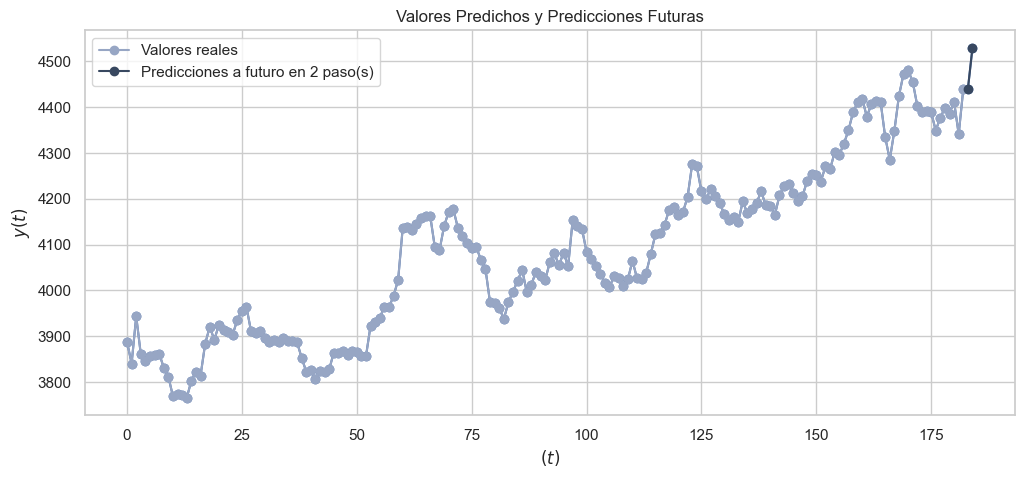

In [93]:
imprimir_predicciones(values)

## <Center> **RESULTADOS**</center>

In [94]:
 # Lista de divisas y modelos
currencies = ['EUR', 'USD', 'CAD', 'GBP']
models = {
    'Linear Regression': lr,
    'Random Forest': rf,
    'LSTM': lstm,
    'Conv_LSTM': hybrid
}

# Crear una lista para almacenar los resultados
results = []

# Iterar sobre cada par de divisas, cada modelo y cada número de años
for i in range(len(currencies)):
    for j in range(len(currencies)):
        if i != j:  # Evitar pares de divisas iguales (por ejemplo, USD/USD)
            for model_name, model_instance in models.items():
                for years in range(2, 11):  # Iterar sobre los años de datos (de 2 a 10)
                    # Entrenar el modelo y obtener la pérdida
                    _, _, model_loss, _ = entrenar_modelo(alpha=0.9, modelo=model_instance, 
                                                          Curr_1=currencies[i], Curr_2=currencies[j], 
                                                          years=years, num_lags=num_lags, plot=False)
                    
                    # Formatear el valor de la pérdida del modelo
                    if model_loss < 1e-10:
                        formatted_loss = f"{model_loss:.10e}"
                    else:
                        formatted_loss = f"{model_loss:.10f}"
                    
                    # Almacenar los resultados en la lista
                    results.append({
                        'Currency Pair': f'{currencies[i]}/{currencies[j]}',
                        'Years': years,
                        'Model': model_name,
                        'Model Loss': formatted_loss
                    })

# Convertir los resultados a un DataFrame de pandas
results_df = pd.DataFrame(results)

In [95]:
results_df['Model Loss'] = pd.to_numeric(results_df['Model Loss'], errors='coerce')
results_df.head(5)

,Currency Pair,Years,Model,Model Loss
0,EUR/USD,2,Linear Regression,8.900000e-09
1,EUR/USD,3,Linear Regression,2.750000e-08
2,EUR/USD,4,Linear Regression,8.100000e-09
3,EUR/USD,5,Linear Regression,5.200000e-09
4,EUR/USD,6,Linear Regression,5.200000e-09


In [96]:
# Pivotar la tabla para que cada modelo sea una columna
df_pivot = results_df.pivot_table(index='Currency Pair', columns='Model', values='Model Loss')
df_pivot.head()

Model,Conv_LSTM,LSTM,Linear Regression,Random Forest
Currency Pair,,,,
CAD/EUR,1.403333e-07,3.921333e-07,4.844444e-09,0.000004
CAD/GBP,3.585556e-07,2.848933e-06,1.901111e-08,0.000055
CAD/USD,3.718889e-07,4.741444e-07,1.012222e-08,0.000009
EUR/CAD,4.347444e-07,1.751578e-06,1.930000e-08,0.000020
EUR/GBP,4.207889e-07,5.781556e-07,2.217778e-08,0.000006


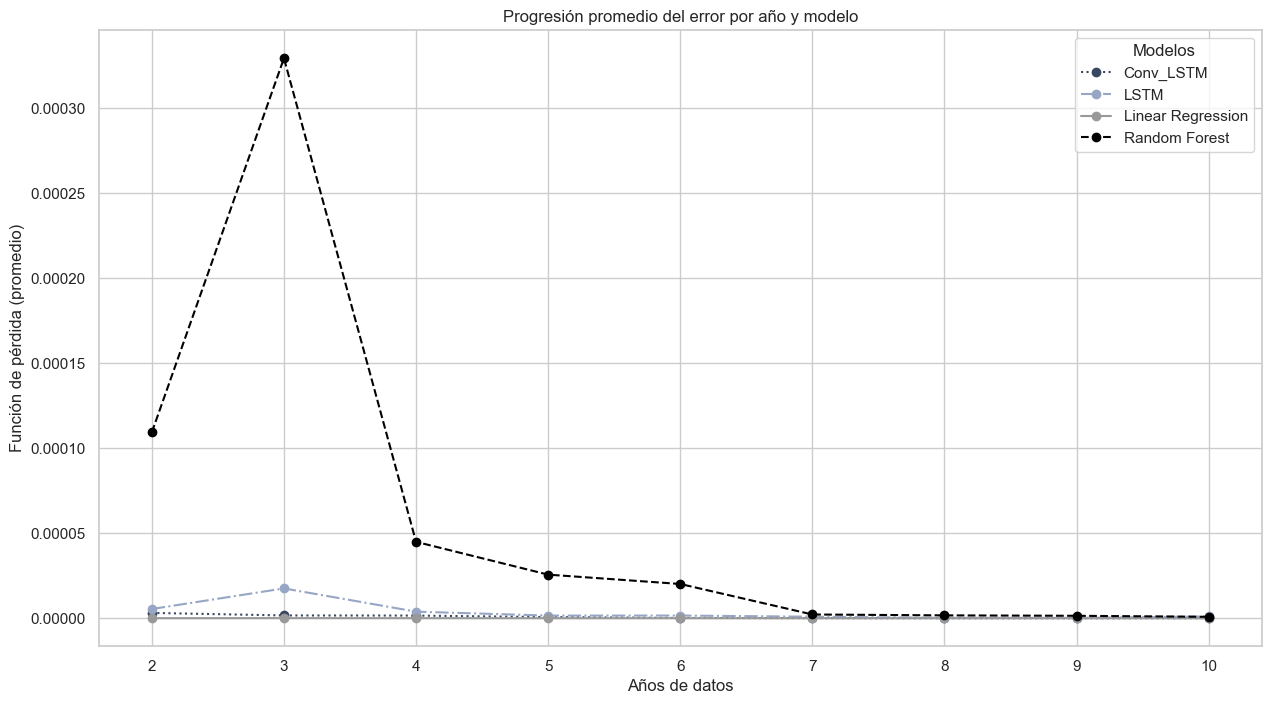

In [97]:
# Agrupar los resultados por 'Years' y 'Model' y calcular el promedio de 'Model Loss'
avg_loss_df = results_df.groupby(['Years', 'Model']).agg({'Model Loss': 'mean'}).reset_index()
grayscale_colors = ['#384860', '#97a6c4', '#999999', '#000000']

# Definir tipos de línea para cada modelo
line_styles = {
    'Linear Regression': '-',
    'Random Forest': '--',
    'LSTM': '-.',
    'Conv_LSTM': ':'
}

# Crear el gráfico
plt.figure(figsize=(15, 8))

# Iterar sobre cada modelo para graficar
for i, model_name in enumerate(avg_loss_df['Model'].unique()):
    model_data = avg_loss_df[avg_loss_df['Model'] == model_name]
    # Asignar color y estilo de línea a cada modelo
    plt.plot(model_data['Years'], model_data['Model Loss'], 
             label=model_name, 
             color=grayscale_colors[i], 
             linestyle=line_styles[model_name], 
             marker='o')

# Añadir título y etiquetas
plt.title('Progresión promedio del error por año y modelo')
plt.xlabel('Años de datos')
plt.ylabel('Función de pérdida (promedio)')
plt.legend(title='Modelos')

# Mostrar el gráfico
plt.grid(True)
plt.show()

En general el modelo híbrido, Conv_LSTM, tiene un mejor desempeño que el resto de modelos en casi todos los tamaños de la serie temporal con la que se entrena, esto se puede deber a que este modelo aprovecha su capa convolusional para extraer características de los datos que permiten al modelo LSTM entender mejor los patrones y cambios en los datos aunque estos sean pequeños. Así mismo, el modelo LSTM muestra un buen desempeño conforme el número de años crece casi igualándose con el modelo híbrido.

Por otra parte, la función de pérdida del modelo de base (LinearRegression) mantiene un error casi constante sin importar el número de años de datos que se le proporcionen. El modelo de RandomForest por su parte, mejora considerablemente conforme más datos tiene, sin embargo, la función de pérdida no es lo suficientemente buena respecto al resto de modelos si no hasta que el tamaño de la serie temporal es bastante grande.

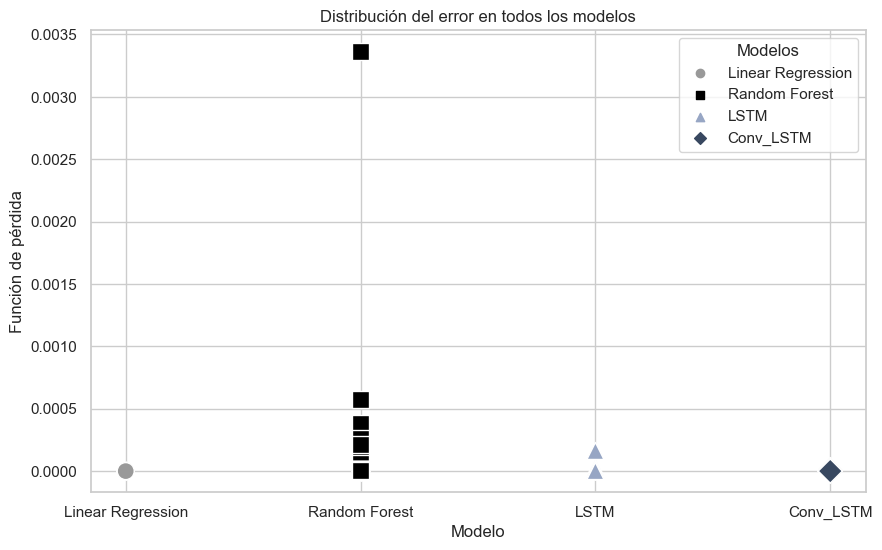

In [98]:
# Establecer el estilo de Seaborn
sns.set(style="whitegrid")
grayscale_colors = ['#999999', '#000000', '#97a6c4', '#384860']

# Crear el gráfico de dispersión con Seaborn
plt.figure(figsize=(10, 6))

# Usar sns.scatterplot para crear el gráfico
sns.scatterplot(data=results_df, 
                x='Model',  # Usamos 'Model' en el eje X para mostrar todos los modelos
                y='Model Loss', 
                hue='Model',  # Diferenciar por modelo
                palette=grayscale_colors,  # Usar una paleta de grises
                style='Model',  # Diferenciar por tipo de modelo
                markers={'Linear Regression': 'o', 
                         'Random Forest': 's', 
                         'LSTM': '^', 
                         'Conv_LSTM': 'D'},  # Estilo de marcador para cada modelo
                s=150,  # Tamaño de los puntos
                alpha=1)  # Transparencia para evitar superposiciones

# Añadir título y etiquetas
plt.title('Distribución del error en todos los modelos')
plt.xlabel('Modelo')
plt.ylabel('Función de pérdida')

# Mostrar leyenda
plt.legend(title='Modelos')

# Mostrar el gráfico
plt.show()

A partir de este gráfico se observa que RandomForest tiene una varianza muy grande en la función de pérdida respecto al resto de modelos cuando generaliza sobre datos desconocidos, por otra parte, el modelo LSTM tiende a tener mayor varianza que el modelo de base aunque sus predicciones sean mejores conforme el tamaño de la serie de tiempo crece. Por último, la varianza del modelo de LinearRegression es la más pequeña, aunque no sea el modelo que mejor generaliza sobre datos nuevos.

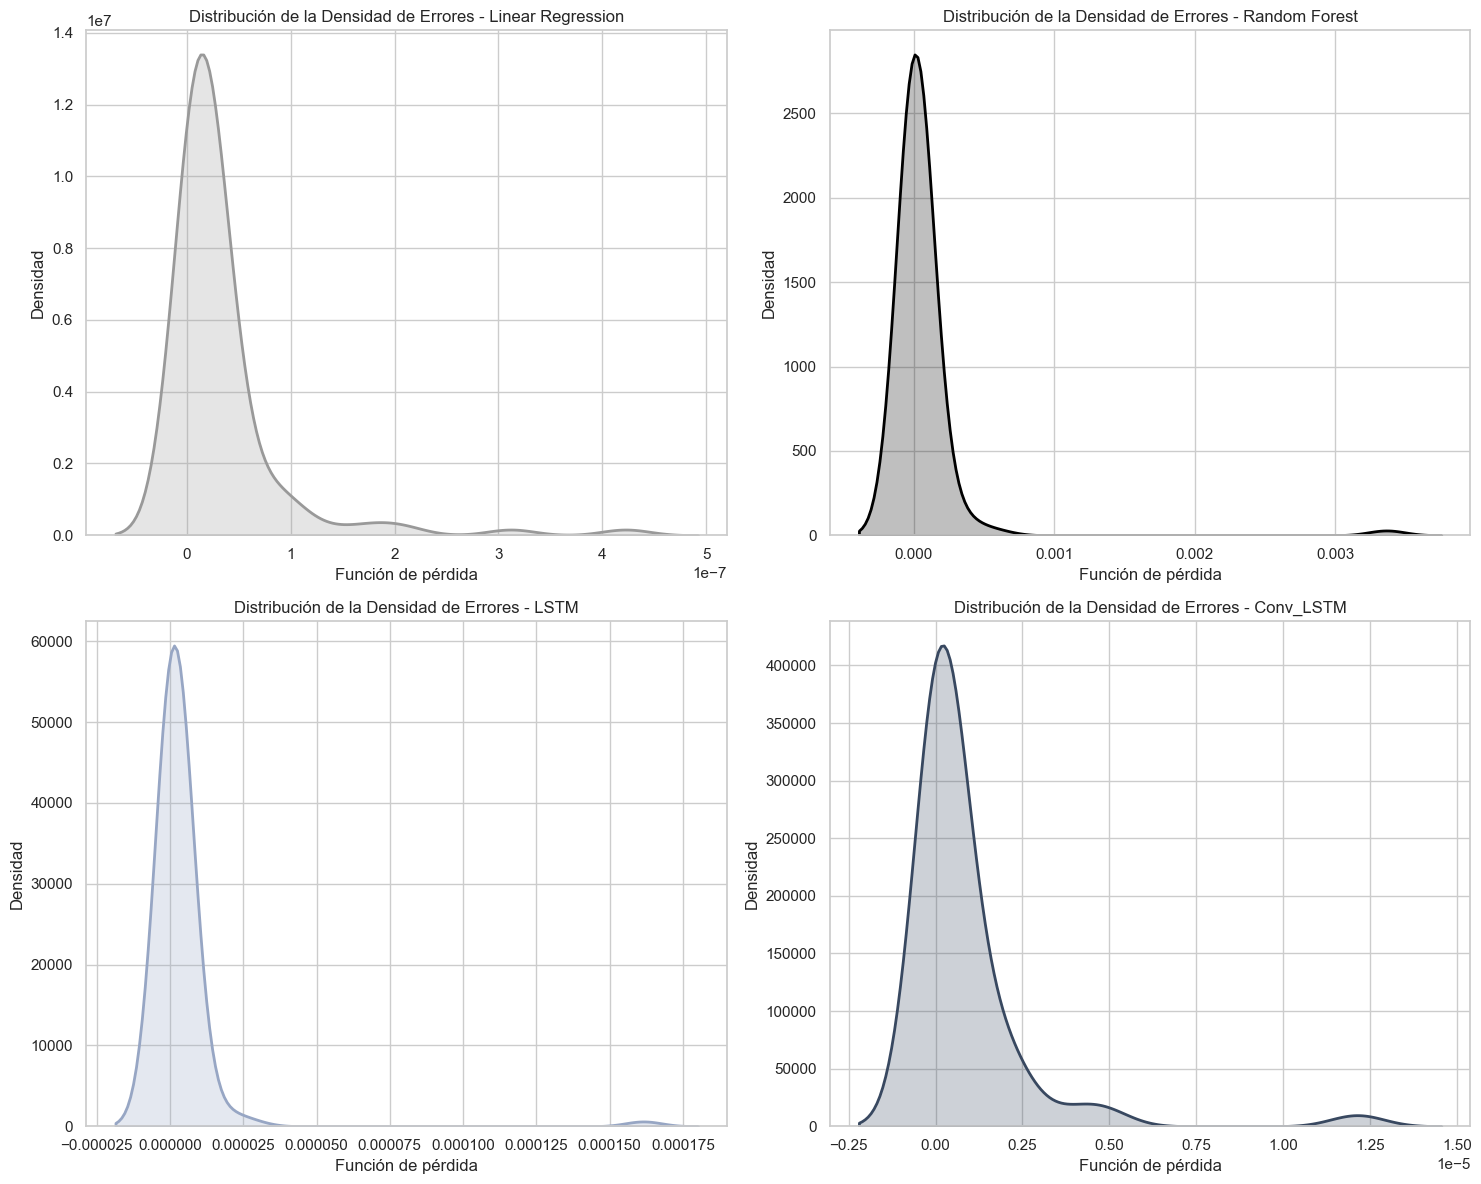

In [99]:
# Establecer el estilo de Seaborn
sns.set(style="whitegrid")

# Obtener los modelos únicos
models = results_df['Model'].unique()

# Crear los gráficos de densidad por modelo
plt.figure(figsize=(15, 12))

for i, model in enumerate(models):
    plt.subplot(2, 2, i + 1)  # Crear subgráficos en una parrilla 2x2
    sns.kdeplot(data=results_df[results_df['Model'] == model], x="Model Loss", fill=True,
                color=grayscale_colors[i], linewidth=2)
    plt.title(f"Distribución de la Densidad de Errores - {model}")
    plt.xlabel("Función de pérdida")
    plt.ylabel("Densidad")

# Ajustar el diseño
plt.tight_layout()
plt.show()

La distribución de la densidad de los errores para el modelo de LinearRegression muestra ser la mejor con una función de pérdida cercana a 1e-7, mientras LSTM y el modelo híbrido tiene un rendimiento similar en escala de 1e-5, por otra parte, el modelo de random forest muestra un error en escala de 1e-03, sin embargo, la varianza de este modelo es más grande como se observó en análisis anteriores.